## Potential Flows

Suppose we want to estimate the optimal transport map from $P$ to $Q$ using iid samples $\{X_i\}_{i=1}^n \sim P$ and $\{Y_i\}_{i=1}^n \sim Q$. The dual objective is given by
$$\min_{f \in CVX(P)} \sum_i f(X_i) + f^*(Y_i).$$

#### Some notation

1. Let $p: \mathbb{R} \to \mathbb{R}$ denote the rational quadratic spline. Consequently, $x \mapsto p(x; \theta)$ is scalar to scalar non-linear monotonic function.
2. Let $\phi: \mathbb{R} \to \mathbb{R}$ denote the integral of the RQ spline. Consequently, $x \mapsto \phi(x; \theta) = \int_{-B}^x p(y; \theta) dy$ is scalar to scalar convex function.
3. Let $T^A_{i}: \mathbb{R}^d \to \mathbb{R}^d$ be an affine map given by $x \mapsto A_iX + b_i$ with positive elements in $A_i$. The parameters of this map are $\theta_i := (A_i, b_i)$.
4. Let $T^S_{j}: \mathbb{R}^d \to \mathbb{R}^d$ be a map given by $x \mapsto [p(x_1; \theta_j^1), \dots, p(x_d; \theta_j^d)]$. The parameters of this map are the spline parameters of $d$ splines denoted by $\theta_j := (\theta_j^1, \dots, \theta_j^d)$.
5. Finally, $\Phi: \mathbb{R}^d \to \mathbb{R}$ is an input convex function given by sum of $d$ spline integrals $x \mapsto \sum_{k=1}^d \phi(x_k; \theta^k)$. The parameters of this map are the spline parameters of $d$ splines denoted by $\theta := (\theta^1, \dots, \theta^d)$.

Let 
$$T = T_k^A \circ T_{k-1}^S \circ \dots \circ T_2^S \circ T_1^A$$
be a composition of affine and RQ spline based componentwise non-linear trasnport layers. This composition is a non-linear monotonic function. Finally, we parameterize $f$ as 
$$f_\theta(x) = \Phi(T(x))$$
where $\theta = (\theta^1, \dots, \theta^d, A_k, b_k, \theta_{k-1}, \dots, \theta_2, A_1, b_1)$ are the parameters of transports $T_1, \dots, T_k$ and of the final input convex function $\Phi$. Since convex function composed with monotonic function is a convex function of the inputs, $f_\theta$ is an input-convex function parameterization.

Unlike previously, $\nabla f_\theta$ is not a diagonal map unless $T$ is an identity function because
$$\nabla_x f_\theta (x) = \nabla f_{\theta}(T(x))\,\, J T(x).$$

Note that 
$$\nabla f_{\theta}(y) = [p(y_1; \theta^1), \dots, p(y_d; \theta^d)]$$
and 
$$JT(x) = JT_{k}(S_{k-1}(x)) \,\, J T_{k-1}(S_{k-2}(X)) \cdots JT_1(x)$$
where $S_j(x) = T_j \circ \cdots T_1(x)$.
For an affine monotonic layer $J T^A_j(x) = A_j$ and $J T^S_j(x) = \text{diag}(p'(x_1; \theta_j^1), \dots, p'(x_d; \theta_j^d))$.

In order to minimize the dual objective, we need $\nabla_\theta f_\theta(x)$ and $\nabla_\theta f_\theta^*(y)$. The former is available via autodiff. For latter, we know that
$$f_\theta^*(y) = \langle y, (\nabla f_\theta)^{-1}(y)\rangle - f_\theta (\nabla f_\theta)^{-1}(y)).$$

However $\nabla (f_\theta)^{-1}(y)$ is not available in closed form and we need to calculate it numerically by solving the following problem
$$(\nabla f_\theta)^{-1}(y) = \argmax_{x}  \left(\langle x, y \rangle - f_\theta (x)\right).$$

Let the numerical solution to above problem be $x^*_\theta$, then the optimality condition gives
$$\nabla_\theta f_\theta^*(y) \approx -\nabla_\theta f_{\theta}(x^*_\theta).$$

Now with access to $\nabla_\theta f_{\theta}$ and $\nabla_\theta f^*_{\theta}$, we can do gradient descent on the dual objective.

In [1]:
import sys
sys.path.append("../../")
from potential_flows import transforms
from potential_flows import potential
import torch
import numpy as np
from tqdm import tqdm
from torch.nn import functional as F
import matplotlib.pyplot as plt

#### Creating source and target data

In [2]:
n = 1000
d = 2
x1 = torch.randn(n,1)
x2 = x1.pow(2) + torch.randn(n,1)
from_data = torch.cat([x1,x2], dim=-1)
to_data = torch.randn(n,d)

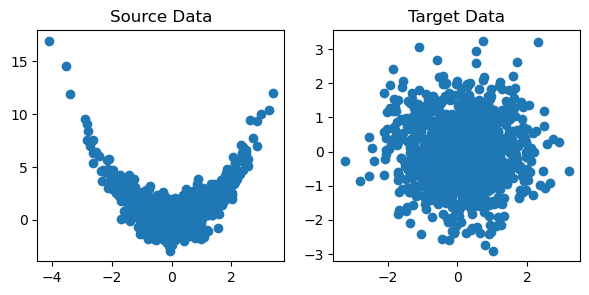

In [3]:
fig, axs = plt.subplots(1, 2, figsize = (7,3))
axs[0].scatter(x1,x2)
axs[0].set_title("Source Data")
axs[1].scatter(to_data[:,0], to_data[:,1])
axs[1].set_title("Target Data")
plt.show()

#### Creating the flow

In [4]:
torch.manual_seed(42)
layer_identity = transforms.IdentityTransform()
layer_affine1 = transforms.PositiveLinear(d)
layer_spline1 = transforms.RQspline(data_shape=(d,), num_bins=4, tail_bound=1.5)
layer_affine2 = transforms.PositiveLinear(d)
layer_spline2 = transforms.RQintegral(data_shape=(d,), num_bins=4, tail_bound=1.5)
layers = transforms.CompositeTransform([layer_spline2]) # T
potential_flow = potential.ICRQ(layers, data_shape=(d,))
potential_flow

/home/medhaaga/OT_flow/potential_flows/flow/../../potential_flows/transforms/utils.py:51: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2425.)
  q, _ = torch.qr(x)


ICRQ(
  (Tmap): CompositeTransform(
    (_transforms): ModuleList(
      (0): IdentityTransform()
      (1): CompositeTransform(
        (_transforms): ModuleList(
          (0): RQintegral()
        )
      )
    )
  )
)

#### Plotting $T$ and $\nabla_X f$
which are both monotonic $\mathbb{R}^d \to \mathbb{R}^d$ functions

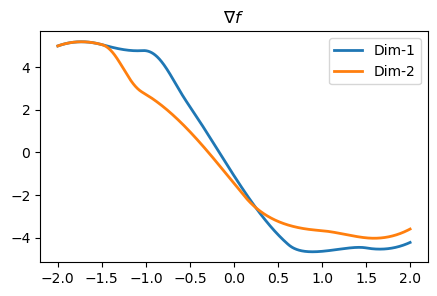

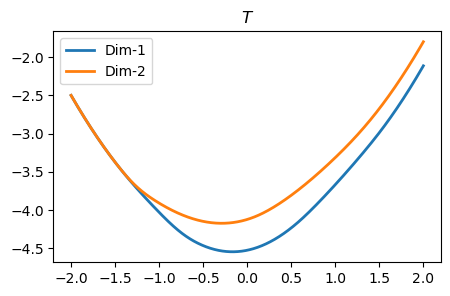

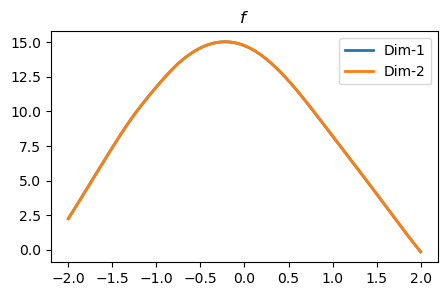

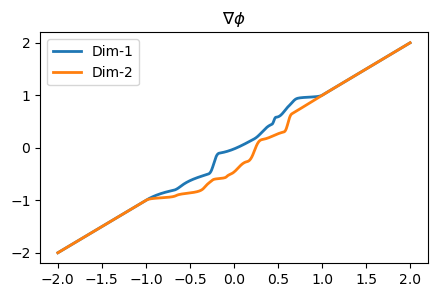

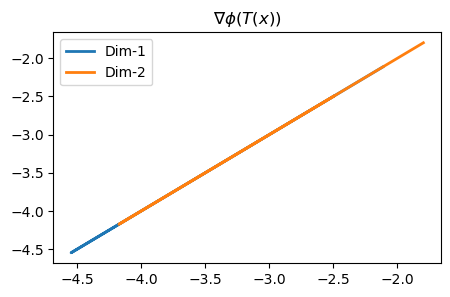

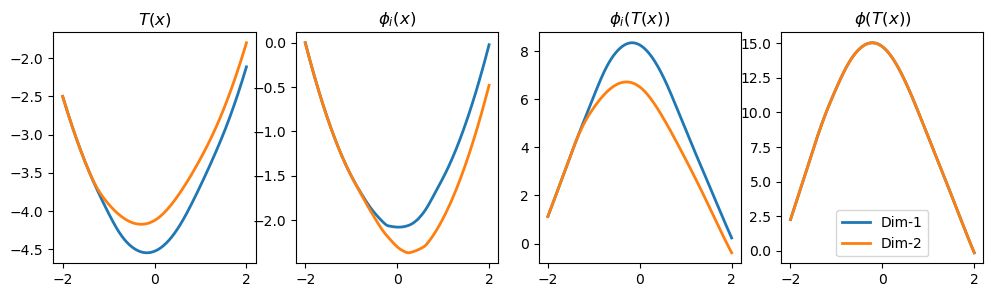

In [5]:

potential_flow.plot_flow(1000)
potential_flow.plot_Tmap(1000)
potential_flow.plot_potential(1000)
potential_flow.plot_grad_potential(1000)
potential_flow.grad_phi_T(1000)
potential_flow.plot_spline_integral(1000)

tensor([[0.8050, 1.9389]]) tensor([[0.8092, 1.9265]])


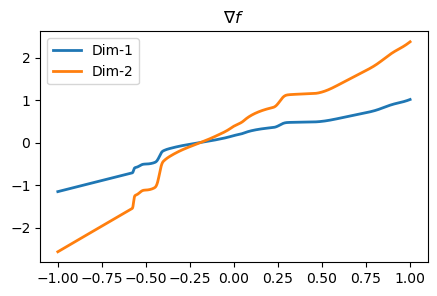

In [172]:
print(potential_flow.gradient(torch.tensor([[.5,1.]])), potential_flow.gradient(torch.tensor([[0.8373, 0.8370]])))
inputs = torch.cat([torch.linspace(-1, 1, 1000).unsqueeze(-1)]*np.prod((d,)), dim=1)
inputs.requires_grad = True
forward_vals = potential_flow.gradient(inputs)
plt.figure(figsize=(5, 3))
for i in range(d):
    plt.plot(inputs.detach().cpu().numpy()[:, i], forward_vals.detach().cpu().numpy()[:, i], label='Dim-{}'.format(i+1), linewidth=2)
plt.title(r'$\nabla f$')
plt.legend()
plt.show()

#### Calculating $(\nabla_x f_\theta)^{-1}(Y_i)$

We need to calculate $(\nabla_x f_\theta)^{-1}(Y_i)$ for all $i \in \{1, \dots, n\}$. However solving the problem
$$X_{\theta i}^* =: \nabla (f_\theta)^{-1}(Y_i) = \argmax_{x} \langle Y_i, X\rangle - f_\theta(X)$$
in a loop for all $i$ is not feasible computationally. So we define the objective function `objective_function` that returns 
$$ - \sum_i \langle Y_i, X\rangle - f_\theta(Y_i)$$
to be minimized for calculating approximate $n \times d$ tensor $[(\nabla f)^{-1}(Y_1), \dots, (\nabla f)^{-1}(Y_n)]$.

In [173]:
def objective_function(x, y, potential_flow):
    '''
    y: n * d
    x: n * d
    potential_flow: potential function
    '''
    return -torch.sum(x*y, dim=-1) + potential_flow.integral(x)


def approx_inv_flow(potential_flow, y, x, inner_iter=100):
    '''
    y: n * d
    '''
    x0 = torch.zeros(y.shape, requires_grad=True)
    x0.requires_grad = True
    optimizer = torch.optim.LBFGS([x0], lr=.001)
    potential_flow.requires_grad_(False)
    losses, error = [], []
    def closure():
        optimizer.zero_grad()  # Clear previous gradients
        loss = objective_function(x0, y, potential_flow)
        losses.append(loss.item())
        loss.backward()  # Compute gradients
        return loss
    for i in tqdm(range(inner_iter)):
        optimizer.step(closure)
        error.append(torch.norm(x0 - x).item())
    optimized_parameters = x0.detach()
    return optimized_parameters, losses, error



In [174]:
x_test = torch.tensor([[0.5, 1]], requires_grad=True)
y_test = potential_flow.gradient(x_test)
print(f'x: {x_test} \n y: {y_test}')

x: tensor([[0.5000, 1.0000]], requires_grad=True) 
 y: tensor([[0.8050, 1.9389]])


In [175]:

z_test, losses, error = approx_inv_flow(potential_flow, y_test.detach(), x_test.detach(), inner_iter=500)
print(f'x: {x_test} \n y: {y_test} \n grad_f_inv_y: {z_test} \n error: {torch.norm(x_test - z_test)}')

100%|██████████| 500/500 [00:22<00:00, 22.57it/s]

x: tensor([[0.5000, 1.0000]], requires_grad=True) 
 y: tensor([[0.8050, 1.9389]]) 
 grad_f_inv_y: tensor([[0.5268, 0.9794]]) 
 error: 0.033797502517700195


In [176]:
y_z_test = potential_flow.gradient(z_test)
print(f'z: {z_test} \n z_y: {y_z_test}')

z: tensor([[0.5268, 0.9794]], requires_grad=True) 
 z_y: tensor([[0.7986, 1.9234]])


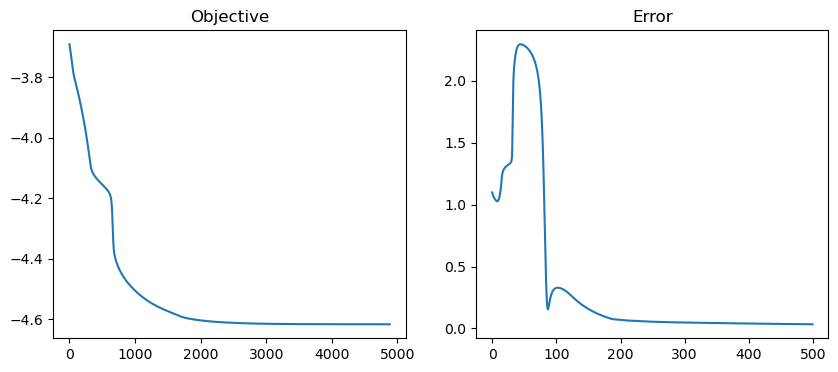

In [177]:
fig, axs = plt.subplots(1,2, figsize = (10,4))
axs[0].plot(losses)
axs[0].set_title("Objective")
axs[1].plot(error)
axs[1].set_title("Error")
plt.show()

In [146]:
x_test = torch.tensor([[-.0, 0.]], requires_grad=True)
y_test = potential_flow.gradient(x_test)
h = 1e-4
print((potential_flow.integral(x_test + torch.tensor([[h, 0]])) - potential_flow.integral(x_test) )/h, (potential_flow.integral(x_test + torch.tensor([[0, h]])) - potential_flow.integral(x_test) )/h, y_test)

tensor([-0.2313], grad_fn=<DivBackward0>) tensor([0.0215], grad_fn=<DivBackward0>) tensor([[-0.2314,  0.0211]])


In [71]:
# def objective_function2(x, y, potential_flow):
#     return -torch.sum(x*y, dim=-1) - potential_flow.integral(x)

# def approx_inv_flow2(potential_flow, y, inner_iter=100, tolerance=1e-4):
#     n = y.shape[0]
#     x0 = torch.ones(y.shape).to("cuda")
#     x0.requires_grad = True
#     potential_flow.requires_grad_(False)
#     optimizer = torch.optim.Adam([x0], lr=.001)

#     for i in tqdm(range(inner_iter)):
#         prev_x0 = x0.clone().detach()
#         j = torch.randint(0, n, (1,))
#         optimizer.zero_grad()
#         loss = objective_function2(x0[j], y[j], potential_flow)
#         loss.backward()  # Compute gradients
#         optimizer.step()
        
#         if torch.norm(x0 - prev_x0) < tolerance:
#             print("Converged")
#             break
#         if i%100 == 0:
#             print(f'Step {i}, Component {j}: Objective = {loss.item()}')

#     optimized_parameters = x0.detach()
#     return optimized_parameters

In [ ]:
# x_star = approx_inv_flow2(potential_flow, torch.ones(n,d, requires_grad=True).to("cuda"), 10*n)

#### Plotting the `objective_function` vs $X$ for a fixed $Y$

In [38]:
def dummy(x, y, potential_flow):
    return torch.sum(x*y, dim=-1) - potential_flow.integral(x)
y_test = torch.zeros(n,d).to("cuda")
x_test = torch.linspace(-50,50, n).to("cuda")
z_test = torch.zeros(n,n).to("cuda")
for i in tqdm(range(n)):
    with torch.no_grad():
        foo = torch.cat([x_test[i]*torch.ones(n,1).to("cuda"), x_test.unsqueeze(-1)], dim=1)
        z_test[i,:] = dummy(foo, y_test, potential_flow)


100%|██████████| 1000/1000 [00:13<00:00, 75.99it/s]


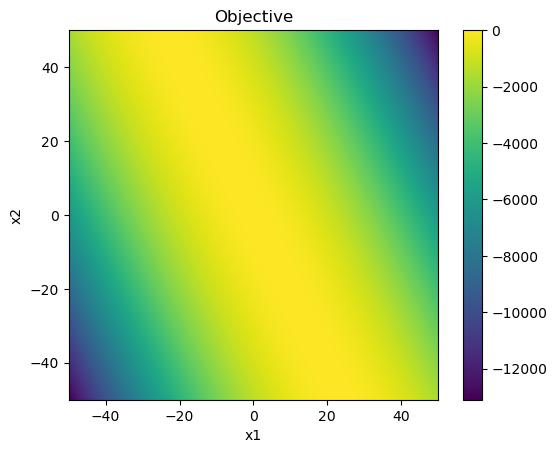

In [39]:
z_test = z_test.detach().cpu().numpy()
x_test = x_test.detach().cpu().numpy()
plt.imshow(z_test, extent=[x_test.min(), x_test.max(), x_test.min(), x_test.max()], origin='lower', cmap='viridis')

# Add a colorbar
plt.colorbar()

# Add labels and a title
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Objective')

# Show the plot
plt.show()

In [147]:
def calculate_loss_gradients(potential_flow, x, y):
    n = x.shape[0]
    with torch.no_grad():
        x_star = approx_inv_flow(potential_flow, y)
        loss = torch.mean(potential_flow.integral(x) + torch.sum(y*x_star, dim=-1) - potential_flow.integral(x_star))
        # print(torch.isnan(x_star).any().item(), torch.mean(potential_flow.integral(x_star)))
    potential_flow.requires_grad_(True)
    grad = torch.sum(potential_flow.integral(x))/n
    grad_conjugate = torch.sum(potential_flow.integral(x_star))/n

    model_gradient = torch.autograd.grad(grad, potential_flow.parameters())
    model_star_gradient = torch.autograd.grad(grad_conjugate, potential_flow.parameters())

    return loss, tuple(a - b for a, b in zip(model_gradient, model_star_gradient))

In [148]:
max_iter = 100
learning_rate = 1e-4
losses = []
for epoch in tqdm(range(max_iter)):
    potential_flow.zero_grad()
    loss, loss_gradient = calculate_loss_gradients(potential_flow, from_data.to("cuda"), to_data.to("cuda"))
    print(f'Loss: {loss}')
    losses.append(loss)
    
    # Update model parameters
    with torch.no_grad():
        
        for param, grad in zip(potential_flow.parameters(), loss_gradient):
            param -= learning_rate * grad
    torch.cuda.empty_cache()

  0%|          | 0/100 [00:01<?, ?it/s]


TypeError: approx_inv_flow() missing 1 required positional argument: 'x'

In [ ]:
model_path = "potential_flow.pth"
torch.save(potential_flow.state_dict(), model_path)


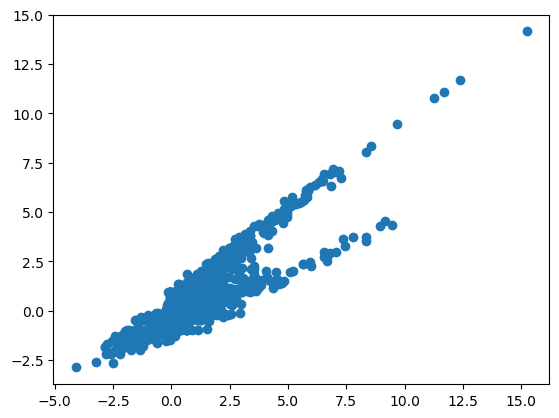

In [ ]:
normalized_data = potential_flow.gradient(from_data).detach()
plt.scatter(normalized_data[:,0], normalized_data[:,1])